In [1]:
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
sns.set_style("dark")

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas_datareader.data import DataReader
import datetime as dt

# libraries for pipeline|
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA


#metrics
import sklearn.metrics as metrics

# Models to try
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC

# custom functions
from modules import functions

# Market Data Gathering

In [2]:
# Important dates
start = dt.datetime(2021,8,14)
end = dt.datetime(2022,8,14)


In [3]:
# import data
nflx = DataReader("NFLX",  "yahoo", start, end)
gspc = DataReader("^GSPC", "yahoo", start, end)

In [4]:
# concatenate stock and market data
features = functions.concatRename(nflx, 'nflx_', gspc, 'gspc_')

# Set-up time series prediction

Pipelines does not support dropping rows in the target data, so we must pre-process here. We take the features from the previous n days and use them to predict 

In [5]:
# target variable name
nflx_target = 'nflx_Adj Close'

# we do not drop the target variable, as we'll be shifting it
X = features
y = features[nflx_target]

In [6]:
# shift features and drop nans
rolling = 1
X_shifted = functions.shiftTime(X, rolling)

# find diff and drop nans
diff_delta = 1
X_diff = functions.trendDiff(X_shifted,diff_delta)

# put together
X_shifted = functions.concatRename(X_shifted, '', X_diff, 'diff_')
X_shifted.dropna(how='any', inplace=True)

# drop rolling rows from y
y_shifted = y.iloc[rolling+diff_delta:]

In [7]:
# take the last 0.20% for validation
X_train, X_test = functions.testSplit(X_shifted)
y_train, y_test = functions.testSplit(y_shifted)

In [8]:
# specify feats for column transformer, those not included will be dropped
num_feats = ['nflx_Adj Close', 'diff_nflx_Adj Close']

# Pipeline

In [9]:
# Feature Engineering Pipelines

num_transform = Pipeline([
    ('Imputer', KNNImputer()),
    ('scaling', StandardScaler()),
    ('select_best', SelectKBest(k=5)),
    ])

In [10]:
feature_engineering = ColumnTransformer([
    ('num_transform', num_transform, num_feats),
    ('scaling', StandardScaler()),
    ], remainder='drop')# 

In [11]:
# feature_engineering = 

In [12]:
pipeline = Pipeline([
    
    ('scaling', StandardScaler()),
    ('classifier', LinearRegression()),
    ])

In [13]:
model = pipeline.fit(X_train, y_train)

In [14]:
y_pred = model.predict(X_test)

In [15]:
functions.regression_results(y_test, y_pred)

explained_variance:  0.8384
mean_squared_log_error:  0.0026
r2:  0.8131
MAE:  8.3468
MSE:  101.3905
RMSE:  10.0693


<AxesSubplot:xlabel='Date'>

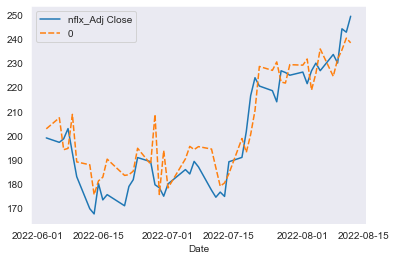

In [19]:
# plot predictions
pred_df = pd.concat([y_test, pd.Series(y_pred, index=y_test.index)], axis=1)
sns.lineplot(data=pred_df)